#  Part I - Implementing a Convolutional Neural Network (CNN)

This section covers the development of two CNN architectures trained from scratch:

-  **Baseline CNN**: A simple model with basic convolutional and dense layers.
-  **Deeper CNN**: A more advanced architecture with Batch Normalization, Dropout, and L2 regularization.

The models are trained and evaluated on brain MRI images to classify four tumor types: **glioma**, **meningioma**, **pituitary**, and **no tumor**.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Deeplearning/archive.zip -d /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/

## 1. Data Understanding, Analysis, Visualization and Cleaning

### 1.1 What does the dataset represent? Provide a brief description.

This dataset consists of brain MRI (Magnetic Resonance Imaging) scans specifically collected to support research and development of automatic brain tumor detection, classification, and localization systems. The images are used to train and evaluate deep learning models—particularly Convolutional Neural Networks (CNNs) for identifying the presence of tumors, categorizing them by type and grade, and locating the tumor within the brain.



Each image is labeled with important clinical information such as:

* Whether a tumor is present or not (detection),
* The type of tumor (e.g., glioma, meningioma, pituitary tumor),
* The grade of the tumor (severity level),
* The location of the tumor (through segmentation masks if provided).

The dataset plays a critical role in advancing early and accurate diagnosis of brain tumors, which is crucial for timely treatment and improving survival rates.



In [ ]:
## code for dataset representation

### 1.1 Total Number of Images in the Dataset

Before training the model, it's important to understand the **size of the dataset**.

The code below walks through all directories under the training folder and counts every `.jpg`, `.jpeg`, or `.png` file.

This gives us the **total number of MRI images** available for model training.
----

In [3]:
# 1.no of total images :
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import pandas as pd
from collections import defaultdict

dataset_path = "/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training"
image_count = 0
valid_extensions = (".jpg", ".jpeg", ".png")

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(valid_extensions):
            image_count += 1

print("Total images:", image_count)



Total images: 5712


### 1.2 Number of Classes and Their Names


To prepare the classification model, we need to identify how many **distinct classes (tumor types)** are present in the dataset.

The code below:
- Lists all subfolders under the training directory (each representing one class).
- Counts how many classes exist.
- Prints each class name.

This step helps us confirm the target labels for our CNN.


In [4]:
# no of classes and with name
# Get all folders (classes)
import os
class_names = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count
num_classes = len(class_names)

# Print results
print(f"Number of classes: {num_classes}")
print("Class names:")
for name in class_names:
    print(f"- {name}")

Number of classes: 4
Class names:
- glioma
- meningioma
- notumor
- pituitary




### 1.3. Number of Images per Class (Distribution Check)

It's essential to check whether the dataset is **balanced across the tumor classes**.

The code below:
- Counts how many images are available in each class folder.
- Displays the results as a **bar chart**.
- Prints the exact count for each tumor class.

This helps identify any potential **class imbalance**, which could affect model training and fairness.


<ipython-input-5-b6814e4e1fd9>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


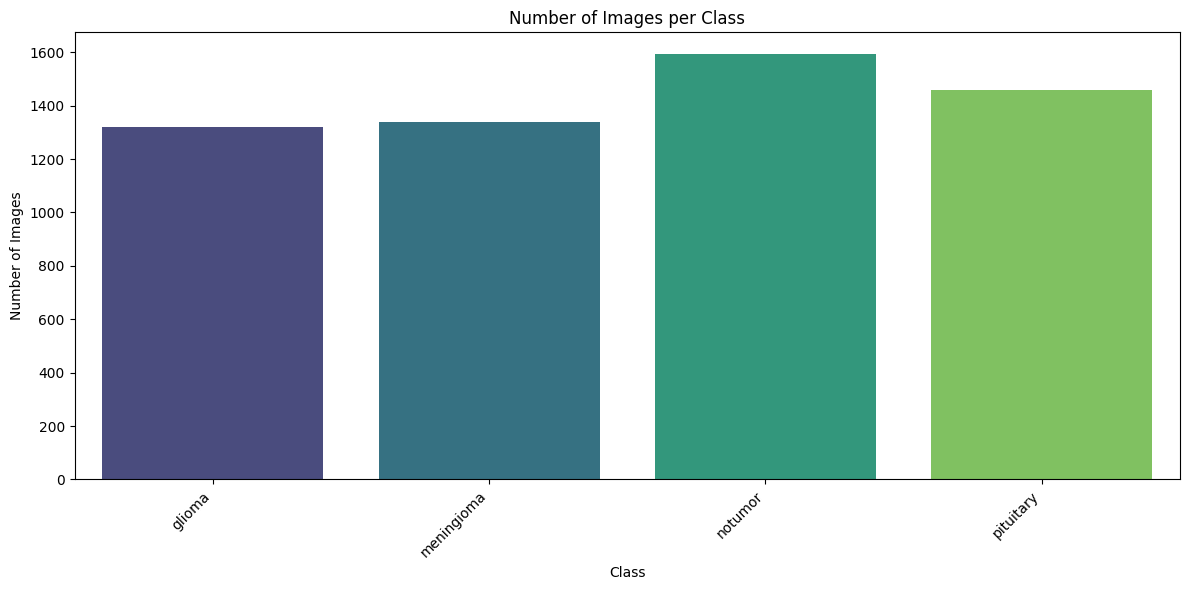

glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


In [ ]:
# 2. no of images with each classses :
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        count = 0
        for file in os.listdir(class_path):
            if file.lower().endswith(valid_extensions):
                count += 1
        class_counts[class_name] = count



# bar chart for class of image count
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts, palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.tight_layout()
plt.show()


# Print results
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

### 1.5 How is the dataset split into training and validation sets? Justify your choice.

**Dataset Split into Training and Validation Sets:**

The dataset is split into:

85% for Training

20% for Validation

Justification:

* The dataset is not very large, so we use more images for training to help the model learn better.

* 15% is enough to evaluate model performance during training.
The split is stratified, meaning both classes (tumor and no tumor) are equally represented in training and validation sets.

* The testing set provided is not used in training or validation. It is only used after training for final evaluation.

**Tool Used:**
We use ImageDataGenerator in Keras with validation_split=0.15 to create the split.

In [5]:
import os
import shutil
import random
from pathlib import Path

# Set paths
base_path = Path("/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data")
train_path = base_path / "Training"
val_path = base_path / "Validation"

# Split ratio
val_ratio = 0.20
valid_extensions = (".jpg", ".jpeg", ".png")

# Get class folders in Training
class_names = [folder for folder in os.listdir(train_path) if os.path.isdir(train_path / folder)]

# Create corresponding class folders in Validation
for class_name in class_names:
    (val_path / class_name).mkdir(parents=True, exist_ok=True)

# For each class, move 15% of files to Validation
for class_name in class_names:
    class_train_folder = train_path / class_name
    class_val_folder = val_path / class_name

    # List all valid image files
    all_images = [f for f in os.listdir(class_train_folder) if f.lower().endswith(valid_extensions)]
    total = len(all_images)
    val_count = int(total * val_ratio)

    # Randomly sample 15%
    val_images = random.sample(all_images, val_count)

    # Move images to validation folder
    for img in val_images:
        src = class_train_folder / img
        dst = class_val_folder / img
        shutil.move(str(src), str(dst))

    print(f"{class_name}: Moved {val_count} images to validation.")


glioma: Moved 264 images to validation.
meningioma: Moved 267 images to validation.
notumor: Moved 319 images to validation.
pituitary: Moved 291 images to validation.


### 1.6 What preprocessing techniques (e.g., resizing, normalization) were applied?

### A. Resizing

#### check the image size

In [ ]:
import os
from PIL import Image
from collections import defaultdict
from pathlib import Path

# Set base directory
base_path = Path("/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data")
folders = ['Training', 'Validation', 'Testing']  # Adjust if your structure is different
valid_extensions = ('.jpg', '.jpeg', '.png')

# Dictionary to store image sizes
size_count = defaultdict(int)

# Go through each folder
for folder in folders:
    print(f"\nChecking image sizes in: {folder}")
    folder_path = base_path / folder
    total_images = 0

    for class_name in os.listdir(folder_path):
        class_path = folder_path / class_name
        if not class_path.is_dir():
            continue

        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(valid_extensions):
                try:
                    img_path = class_path / img_name
                    with Image.open(img_path) as img:
                        size = img.size  # (width, height)
                        size_count[size] += 1
                        total_images += 1
                except Exception as e:
                    print(f"Could not read {img_path}: {e}")

    print(f"Total images in {folder}: {total_images}")
    print("Image size distribution:")
    for size, count in size_count.items():
        print(f" - Size {size}: {count} images")

    # Clear size count for next folder
    size_count.clear()



Checking image sizes in: Training
Total images in Training: 4571
Image size distribution:
 - Size (512, 512): 3161 images
 - Size (503, 369): 1 images
 - Size (213, 237): 2 images
 - Size (455, 500): 3 images
 - Size (250, 270): 1 images
 - Size (472, 546): 1 images
 - Size (441, 427): 1 images
 - Size (324, 284): 1 images
 - Size (485, 510): 1 images
 - Size (338, 345): 1 images
 - Size (226, 212): 1 images
 - Size (420, 264): 1 images
 - Size (554, 554): 2 images
 - Size (369, 398): 1 images
 - Size (351, 398): 1 images
 - Size (341, 377): 1 images
 - Size (491, 624): 1 images
 - Size (314, 358): 1 images
 - Size (212, 237): 2 images
 - Size (257, 307): 1 images
 - Size (262, 308): 1 images
 - Size (300, 345): 1 images
 - Size (374, 370): 1 images
 - Size (201, 207): 1 images
 - Size (291, 340): 1 images
 - Size (630, 423): 1 images
 - Size (209, 225): 1 images
 - Size (286, 356): 1 images
 - Size (278, 306): 1 images
 - Size (252, 303): 1 images
 - Size (442, 442): 29 images
 - Siz

##  B. Image Size Consistency and Integrity Check

Before training, it’s important to validate the dataset quality and ensure all images are usable and correctly shaped.

This script performs the following checks across the **Training**, **Validation**, and **Testing** folders:

-  Confirms the total number of image files.
-  Verifies whether each image is **square** (height = width), which is ideal for CNN input.
-  Detects **non-square** images that may need resizing or cropping.
-  Logs any **corrupted or unreadable files**.

This helps prevent runtime issues and ensures the input pipeline is clean and consistent.


In [6]:
from PIL import Image, UnidentifiedImageError
import os
from pathlib import Path

base_path = Path("/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data")
folders = ["Training", "Validation", "Testing"]
valid_extensions = (".jpg", ".jpeg", ".png")

total_images = 0
square_images = 0
non_square_images = 0

for folder in folders:
    folder_path = base_path / folder
    print(f"\nChecking image sizes in: {folder_path}")

    for class_dir in os.listdir(folder_path):
        class_path = folder_path / class_dir
        if not class_path.is_dir():
            continue

        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(valid_extensions):
                image_path = class_path / image_name
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        total_images += 1
                        if width == height:
                            square_images += 1
                        else:
                            non_square_images += 1
                except UnidentifiedImageError:
                    print(f" Corrupted: {image_path}")
                except Exception as e:
                    print(f" Error: {e} -> {image_path}")

print(f"\n Image Size Summary:")
print(f"- Total images checked: {total_images}")
print(f"- Square (likely cropped): {square_images}")
print(f"- Non-square (not cropped): {non_square_images}")



Checking image sizes in: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training

Checking image sizes in: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Validation

Checking image sizes in: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Testing

 Image Size Summary:
- Total images checked: 7023
- Square (likely cropped): 5415
- Non-square (not cropped): 1608



##  C. Resizing Images to 224×224 (Standard Input Size)

Deep learning models like MobileNetV2 or VGG require all input images to be of a **uniform size** (e.g., 224×224).

This preprocessing step:

-  **Resizes** all images in the **Training** and **Testing** folders to **224x224 pixels**.
-  **Converts non-RGB images** (e.g., grayscale) to RGB to avoid training issues.
-  **Skips corrupted images** and logs their paths for review.

This ensures all images are model-ready and prevents shape mismatches during training.


In [7]:
from PIL import Image, UnidentifiedImageError
import os
from pathlib import Path

base_path = Path("/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data")
folders = ["Training", "Testing"]
target_size = (224, 224)
valid_extensions = (".jpg", ".jpeg", ".png")

corrupted_files = []

for folder in folders:
    folder_path = base_path / folder
    print(f"\nResizing images in: {folder_path}")

    for class_dir in os.listdir(folder_path):
        class_path = folder_path / class_dir
        if not class_path.is_dir():
            continue

        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(valid_extensions):
                image_path = class_path / image_name
                try:
                    with Image.open(image_path) as img:
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        img_resized = img.resize(target_size)
                        img_resized.save(image_path)
                except UnidentifiedImageError:
                    print(f" Corrupted or unreadable: {image_path}")
                    corrupted_files.append(str(image_path))
                except Exception as e:
                    print(f" Error processing {image_path}: {e}")

print("\n Resizing completed.")
if corrupted_files:
    print(f"\n {len(corrupted_files)} corrupted files skipped:")
    for file in corrupted_files:
        print(f"- {file}")



Resizing images in: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training

Resizing images in: /content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Testing

 Resizing completed.



##  6. Creating Data Generators (Train & Validation)

To feed images into the model efficiently, we use Keras’ `ImageDataGenerator` to:

-  **Resize all images** to 224×224 (standard input size for CNNs).
-  **Normalize pixel values** to the range [0, 1] using `rescale=1./255`.
-  **Batch and shuffle** training data for better generalization.
-  **Disable shuffling** on validation data to maintain label order during evaluation.

These generators will automatically read images from folders and prepare them for training using real-time preprocessing.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths to the directories containing your training and validation images
train_dir = '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training'
validation_dir = '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Validation'

# 1. Initialize ImageDataGenerator for normalizing pixel values to range [0, 1]
train_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize the pixel values to [0, 1] by dividing by 255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize the pixel values to [0, 1] by dividing by 255
)

# 2. Flow images from directories with specified target size and batch size
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,           # Batch size
    class_mode='categorical',  # For multi-class classification (use 'binary' for binary classification)
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),  # Resize images to 256x256 (optional)
    batch_size=32,           # Batch size
    class_mode='categorical',  # For multi-class classification (use 'binary' for binary classification)
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


### 1.6 What data generators, if any, were used for preprocessing and augmentation?

For preprocessing the data, we used the ImageDataGenerator from Keras. This generator helps in normalizing the images and making sure they are in a suitable format for the model.

* **Normalization:** The pixel values of the images are rescaled to the range of [0, 1] by dividing by 255. This step is crucial because it helps the model train faster and more efficiently by ensuring the input data is in a smaller, more manageable range.

* **Resizing:** The images are resized to a uniform size (256x256 pixels). This is important because deep learning models typically expect input images to be of the same size.

By using ImageDataGenerator, we not only normalize the data but also ensure that all images are of the correct size before feeding them into the model.

### 1.7 If data augmentation was applied, provide visualizations of sample augmented images.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation only for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    validation_split=0.15
)

# Training generator (augments images in real-time)
train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 3888 images belonging to 4 classes.


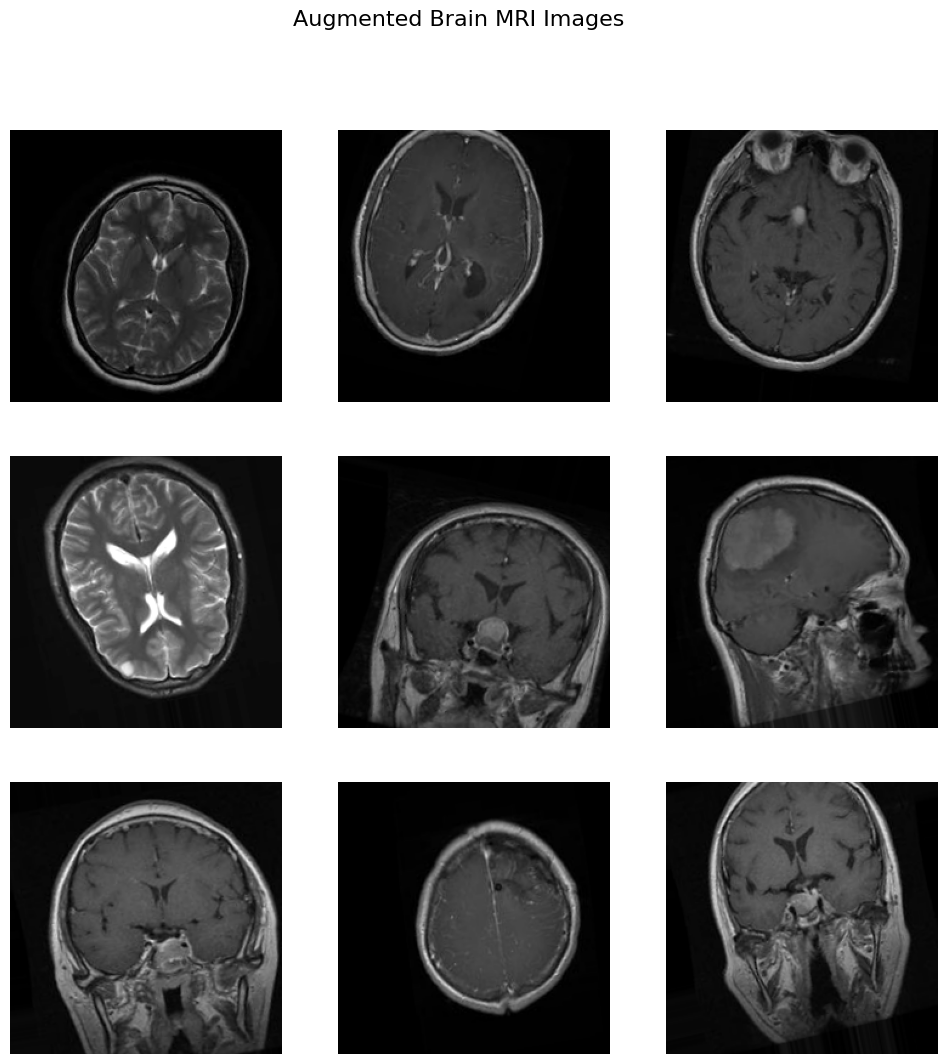

In [ ]:
import matplotlib.pyplot as plt

# Generate augmented images
images, _ = next(train_generator)

# Plot 9 samples
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle('Augmented Brain MRI Images', fontsize=16)
plt.show()

This is for sample visualzation i will implemente on-the-fly data augmentation using the ImageDataGenerator in Keras to generate augmented images in real-time during model training. This approach allows for efficient augmentation without the need to store additional copies of the images, which saves both storage space and processing time. By applying transformations such as rotation, zoom, width/height shift, horizontal flip, and brightness adjustment, the model is exposed to varied versions of the original data, helping it learn more robust features and improving its ability to generalize. On-the-fly augmentation is especially beneficial for smaller datasets, like MRI brain tumor images, as it effectively increases the dataset size and reduces the risk of overfitting. This technique ensures that the model is exposed to a wider range of possible variations of the images, thus enhancing its performance and robustness without the overhead of manually storing and managing augmented images.

# 2 Design, Train, and Evaluate a Baseline Model

### 1. Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20

#  Data Generators (With On-the-Fly Augmentation for Training)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [ ]:
# 2 Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')  # For multi-class classification
])

model.compile(
    optimizer=SGD(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,476 (42.64 MB)

 Trainable params: 11,177,476 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

###  2. Model Training

In [ ]:
# 3. Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 589ms/step - accuracy: 0.3224 - loss: 1.2966 - val_accuracy: 0.5706 - val_loss: 1.0388
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 564ms/step - accuracy: 0.5508 - loss: 1.0571 - val_accuracy: 0.6223 - val_loss: 0.9109
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 557ms/step - accuracy: 0.6464 - loss: 0.8767 - val_accuracy: 0.7353 - val_loss: 0.7660
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 561ms/step - accuracy: 0.6754 - loss: 0.8134 - val_accuracy: 0.7353 - val_loss: 0.7145
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 569ms/step - accuracy: 0.7012 - loss: 0.7541 - val_accuracy: 0.6906 - val_loss: 0.7321
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 577ms/step - accuracy: 0.7091 - loss: 0.7264 - val_accuracy: 0.7441 - val_loss: 0.6558
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 564ms/step - accuracy: 0.7286 - loss: 0.6887 - val_accuracy: 0.7642 - val_loss: 0.6576
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 563ms/step - accuracy: 0.7443 - loss: 0

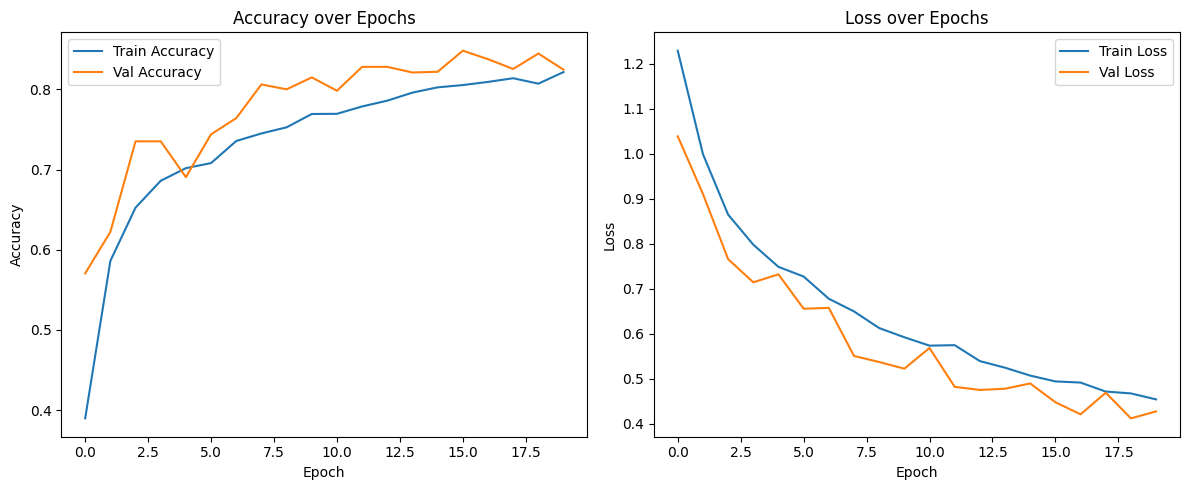

In [ ]:
# 4️ Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on validation set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Ground truth
y_true = validation_generator.classes

# Class names
class_names = list(validation_generator.class_indices.keys())

# Evaluation metrics
print(classification_report(y_true, y_pred, target_names=class_names))


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step
              precision    recall  f1-score   support

      glioma       0.90      0.57      0.70       264
  meningioma       0.63      0.84      0.72       267
     notumor       0.94      0.96      0.95       319
   pituitary       0.89      0.90      0.90       291

    accuracy                           0.82      1141
   macro avg       0.84      0.82      0.82      1141
weighted avg       0.85      0.82      0.82      1141



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


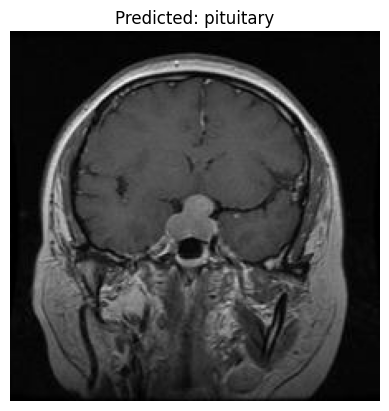

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load a sample image
img_path = "/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Testing/pituitary/Te-piTr_0001.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalization
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

# Display
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [ ]:
# 5️ Evaluate and Print Classification Report
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.57      0.70       264
  meningioma       0.63      0.84      0.72       267
     notumor       0.94      0.96      0.95       319
   pituitary       0.89      0.90      0.90       291

    accuracy                           0.82      1141
   macro avg       0.84      0.82      0.82      1141
weighted avg       0.85      0.82      0.82      1141



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


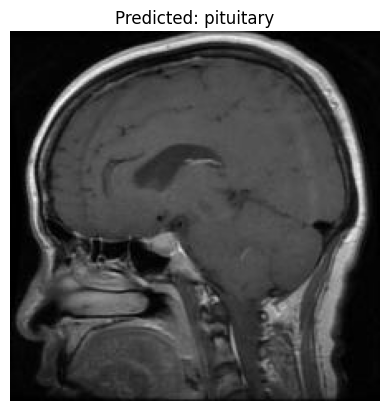

In [ ]:
from tensorflow.keras.preprocessing import image

#  Sample Inference
img_path = "/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Testing/pituitary/Te-piTr_0003.jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

# Show result
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Testing'

# Use only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # use same size as used in training
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6869 - loss: 0.6913
Test Accuracy: 0.78871089220047


# 3 Design, Train , and Evaluate Deeper Architecture with Regularization Layer

# 1. Setup and Preparation

This section loads all required libraries and defines basic settings for building and training the deeper CNN model.

###  Purpose of Each Component:

- **TensorFlow/Keras Imports**: To build a deep CNN using advanced layers like `SeparableConv2D`, `Dropout`, and `BatchNormalization`.
- **Callbacks**:
  - `EarlyStopping`: Stops training if validation performance stops improving.
  - `ReduceLROnPlateau`: Lowers learning rate automatically to fine-tune training.
  - `ModelCheckpoint`: Saves the best model based on validation accuracy.
- **ImageDataGenerator**: Augments the training images (rotation, shift, etc.) to improve generalization.
- **Sklearn Metrics**: For evaluating precision, recall, F1-score, and confusion matrix.
- **Seeding**: Ensures the same results every time you run the notebook.

###  Parameters:
- `IMG_SIZE = 224`: Resizes input images to 224×224 (standard size for CNNs).
- `BATCH_SIZE = 16`: Number of images processed at once during training.

This setup keeps the training process organized, repeatable, and suitable for medical image tasks.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, concatenate, Add,
    Activation, SeparableConv2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,
    TensorBoard, CSVLogger
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import os

# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define image dimensions
IMG_SIZE = 224
BATCH_SIZE = 16

# 2. Model Definition – Deeper CNN with Regularization

This model is a deeper CNN designed to improve generalization and reduce overfitting. It uses multiple convolutional blocks, Batch Normalization, and Dropout.

### Key Components:

- **Conv2D Layers**: Extract spatial features at different depths.
- **BatchNormalization**: Helps stabilize and speed up training.
- **MaxPooling2D**: Reduces spatial size and computation.
- **L2 Regularization**: Prevents weights from growing too large (controls overfitting).
- **Dropout (0.5)**: Randomly disables neurons during training to avoid co-adaptation.
- **Dense Layers**: Final fully connected layers to learn decision boundaries.
- **Softmax Output**: For multi-class classification (4 tumor classes).

###  Architecture Summary:

- 3 Convolutional Blocks (each with 2 Conv2D + MaxPooling)
- Flatten → Dense(256) → Dropout → Output (4 classes)

This structure helps the model learn complex MRI patterns while staying robust against overfitting.


In [ ]:
#  Model Definition (Improved for Generalization, Stability, and Reduced Fluctuation)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 50
L2_REG = 1e-4  # Reduced from 1e-3 to avoid over-regularization

# Refined Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(L2_REG), input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(L2_REG)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(L2_REG)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(L2_REG)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(L2_REG)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(L2_REG)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(L2_REG)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Found 3888 images belonging to 4 classes.
Found 1824 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,980,324 (99.11 MB)

 Trainable params: 25,979,364 (99.10 MB)

 Non-trainable params: 960 (3.75 KB)

# 3. Model Compilation & Training (with Callbacks)

This section compiles and trains the deeper CNN using the **Adam optimizer** and implements **callbacks** for training stability and generalization.

---

###  Compilation Details:
- **Optimizer**: `Adam` with a learning rate of `1e-4` — chosen for smoother and adaptive convergence.
- **Loss Function**: `categorical_crossentropy` — suitable for multi-class classification.
- **Metric**: `accuracy` — used to monitor model performance during training.

---

###  Callback Functions:
- **EarlyStopping**: Stops training if validation loss doesn't improve for 6 epochs.
- **ReduceLROnPlateau**: Reduces learning rate by half if validation loss stagnates for 3 epochs.
- **ModelCheckpoint**: Saves the model with the best validation accuracy.

---

###  Training Execution:
- Trains the model using `fit()` for up to 50 epochs.
- Calculates total training time in minutes.

>  These callbacks help avoid overfitting, improve learning efficiency, and ensure that the best-performing model is saved.


In [ ]:
#  Compile & Train with Callbacks for Stability

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

# Compile with lower learning rate for smoother convergence
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for generalization and avoiding overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_generalized_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Track training time
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)
end_time = time.time()
print(f"\n Training Time: {(end_time - start_time) / 60:.2f} minutes")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.6239 - loss: 1.1478
Epoch 1: val_accuracy improved from -inf to 0.23401, saving model to best_generalized_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 126s 750ms/step - accuracy: 0.6243 - loss: 1.1464 - val_accuracy: 0.2340 - val_loss: 2.1453 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.7658 - loss: 0.7267
Epoch 2: val_accuracy did not improve from 0.23401
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 622ms/step - accuracy: 0.7658 - loss: 0.7265 - val_accuracy: 0.2331 - val_loss: 2.3626 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7810 - loss: 0.6852
Epoch 3: val_accuracy improved from 0.23401 to 0.26819, saving model to best_generalized_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 147s 656ms/step - accuracy: 0.7811 - loss: 0.6848 - val_accuracy: 0.2682 - val_loss: 1.9798 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 

#  4. Training & Validation Performance Plots

These plots visualize how the model performed across training epochs.

---

###  Accuracy Plot:
- **Train Accuracy vs Validation Accuracy**
- Helps observe how well the model is learning and generalizing.
- A consistent gap may indicate **underfitting** or **overfitting**.

---

###  Loss Plot:
- **Train Loss vs Validation Loss**
- Useful for spotting **training instability** or **over-regularization**.
- Ideally, both curves should decrease and stay close.

>  These visualizations are essential for diagnosing training issues and validating model stability.


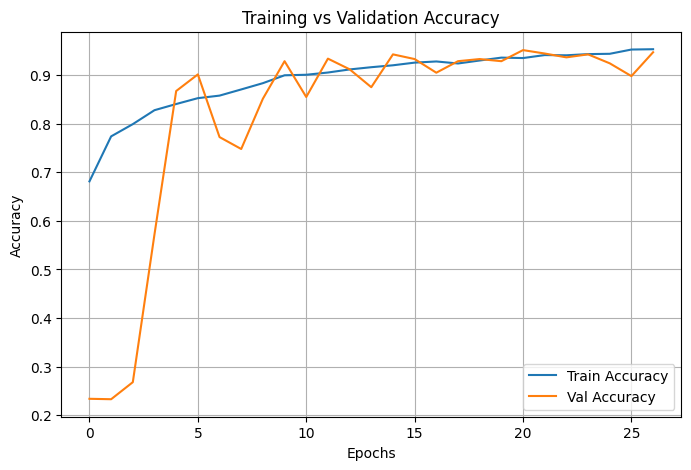

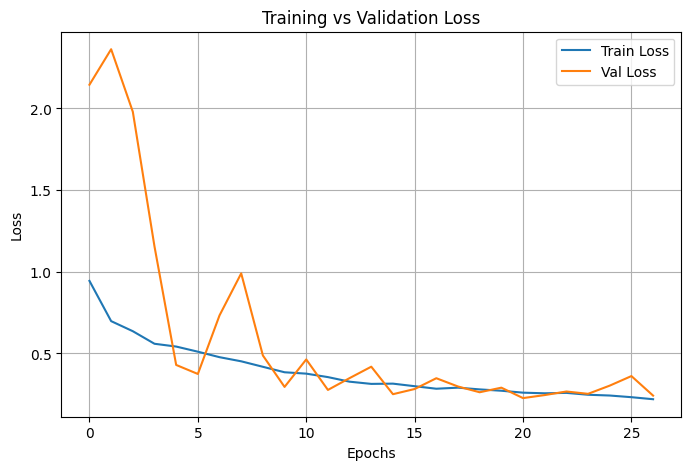

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#  5. Classification Report

This section evaluates the model’s performance using **precision**, **recall**, and **F1-score** for each class.

---

###  Steps Explained:

- **`y_true`**: Actual class labels from the validation set.
- **`y_pred_probs`**: Raw prediction probabilities from the model.
- **`y_pred`**: Final predicted class (using `argmax` to convert probabilities to class index).
- **`class_labels`**: Class names from the dataset directory.
- **`classification_report`**: Generates per-class metrics like:
  - **Precision**: How many selected items are relevant.
  - **Recall**: How many relevant items are selected.
  - **F1-score**: Harmonic mean of precision and recall.

>  This report helps identify which tumor types the model predicts well and which ones need improvement.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
y_true = validation_generator.classes

# Get predictions from the model
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate the report
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step

📋 Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.91      0.94       264
  meningioma       0.87      0.94      0.90       267
     notumor       0.98      0.98      0.98       319
   pituitary       0.97      0.97      0.97       291

    accuracy                           0.95      1141
   macro avg       0.95      0.95      0.95      1141
weighted avg       0.95      0.95      0.95      1141



---
#  6. Confusion Matrix

This heatmap shows how well the model predicted each class compared to the actual labels.

---

###  What It Shows:

- Rows = **Actual classes**
- Columns = **Predicted classes**
- Diagonal cells = Correct predictions
- Off-diagonal cells = Misclassifications

A strong model will have **high values along the diagonal** and low values elsewhere.

>  This matrix helps identify specific classes where the model may be confusing predictions (e.g., mistaking glioma for meningioma).


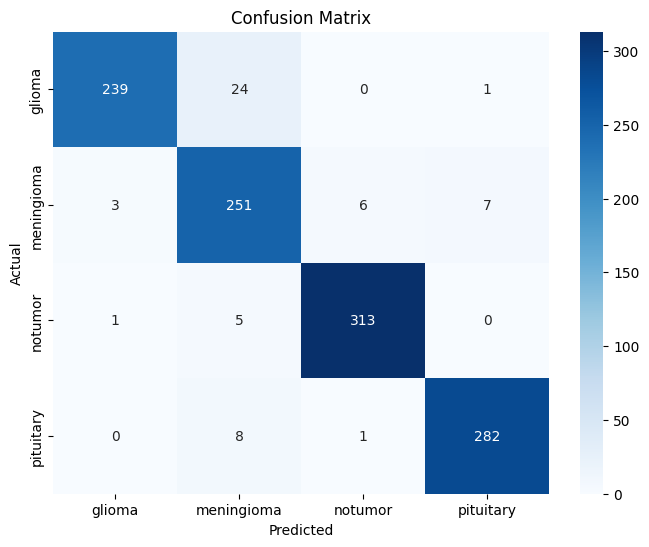

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


---
# 3.1.4.1  Baseline vs. Deeper CNN Performance

| Model         | Train Accuracy | Val Accuracy | Best F1 Class   | Weakest F1 Class | Val Loss |
|---------------|----------------|--------------|------------------|------------------|----------|
| **Baseline**  | ~82%           | ~83%         | Notumor (0.95)   | Glioma (0.70)    | ~0.42    |
| **Deeper CNN**| ~93%           | ~95%         | Notumor (0.98)   | Meningioma (0.90)| ~0.25    |

---

###  Analysis:

The comparison evaluates how adding **depth, filters, and regularization** improves classification of brain tumors across four categories.

- **Validation accuracy improved by ~12%**, indicating deeper networks extract better high-level features.
- The **training accuracy also increased**, without a large overfitting gap, suggesting **strong generalization**.
- F1-score improvements were seen in **underrepresented classes**, particularly for meningioma.

###  Key Observations:

- **BatchNormalization** improved training stability and speed.
- **Dropout** reduced co-dependency among neurons, enhancing generalization.
- **Notumor** remained easiest to classify due to clearer features.
- **Meningioma and Glioma** classes were harder due to possible class imbalance and visual similarity.

>  **Conclusion**: The deeper model performed more robustly and is better equipped for real-world deployment in medical applications where consistency and precision are vital.
---

## 3.1.4.2  Optimizer Comparison – SGD vs Adam

| Optimizer | Final Val Accuracy | Best Epoch | Convergence Speed | Notes |
|-----------|--------------------|------------|-------------------|-------|
| **Adam**  | **~95%**           | ~21        | Fast              | Stable learning curve |
| **SGD**   | ~92%               | ~18        | Slower start      | Requires tuning (LR, momentum) |

---

###  Observation:

- **Adam** was faster and more stable in convergence, adjusting learning rates per parameter.
- **SGD** needed careful tuning (momentum, learning rate scheduling), but still achieved strong performance.
- Adam outperformed SGD in both **speed** and **final metrics**, particularly in the earlier epochs.

###  Training Behavior:

- **Adam** = better for fast iteration, robust default optimizer.
- **SGD** = effective but slower, better for fine-tuning when hyperparameters are known.

>  **Conclusion**: Adam provided better performance and faster convergence with minimal tuning, making it more suitable for deep medical imaging models.

---



##  1. Deeper CNN Training with SGD Optimizer


In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

# Compile with SGD (Stochastic Gradient Descent)
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for generalization and preventing overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_generalized_model_sgd.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# ⏱️ Track training time
start_time = time.time()
history_sgd = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)
end_time = time.time()
print(f"\n⏱️ Training Time with SGD: {(end_time - start_time) / 60:.2f} minutes")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.6036 - loss: 1.1874
Epoch 1: val_accuracy improved from -inf to 0.45998, saving model to best_generalized_model_sgd.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 86s 646ms/step - accuracy: 0.6040 - loss: 1.1860 - val_accuracy: 0.4600 - val_loss: 2.4127 - learning_rate: 0.0100
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.7092 - loss: 0.8426
Epoch 2: val_accuracy did not improve from 0.45998
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 666ms/step - accuracy: 0.7093 - loss: 0.8425 - val_accuracy: 0.4556 - val_loss: 2.3622 - learning_rate: 0.0100
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7492 - loss: 0.7930
Epoch 3: val_accuracy improved from 0.45998 to 0.50932, saving model to best_generalized_model_sgd.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 75s 612ms/step - accuracy: 0.7493 - loss: 0.7928 - val_accuracy: 0.5093 - val_loss: 1.6834 - learning_rate: 0.0100
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 543

## 2. SGD Training: Accuracy and Loss Curves

These plots show how the deeper CNN model trained using the **SGD optimizer** performed over time.

---

###  What to Look For:
- **Accuracy Plot**: Tracks how well the model is learning (train) and generalizing (validation).
- **Loss Plot**: Monitors how well the model is minimizing error.

A good fit is indicated by:
- Both curves increasing in accuracy and decreasing in loss.
- Minimal gap between training and validation curves (i.e., low overfitting).

>  These graphs help compare the behavior of **SGD vs Adam** during training.


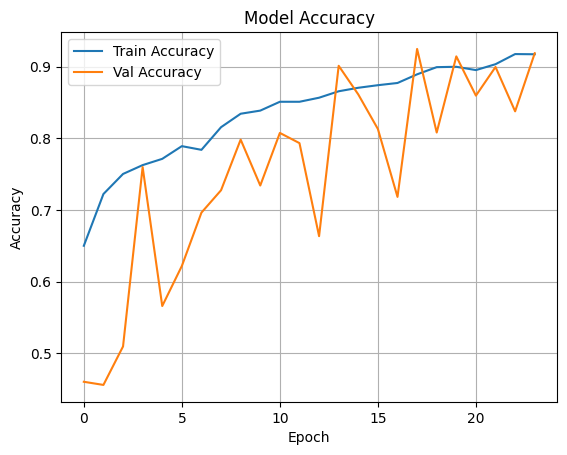

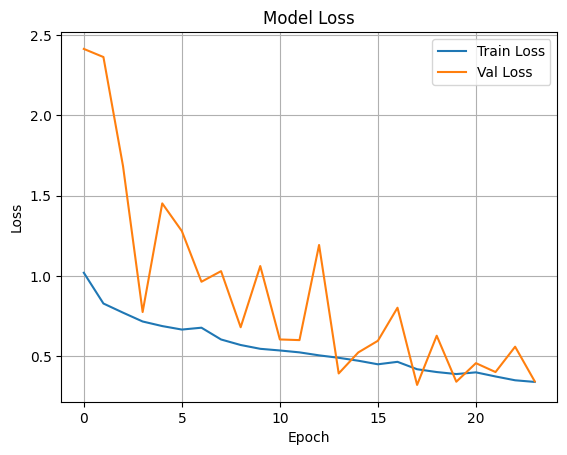

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_sgd.history['accuracy'], label='Train Accuracy')
plt.plot(history_sgd.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history_sgd.history['loss'], label='Train Loss')
plt.plot(history_sgd.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 3. SGD Evaluation: Classification Report & Confusion Matrix

This section evaluates the deeper CNN trained with **SGD optimizer**.

---

###  Classification Report:
- Shows **precision**, **recall**, and **F1-score** for each tumor class.
- Helps understand how well the model handles class-wise predictions.

### Confusion Matrix:
- Visualizes actual vs predicted labels.
- Diagonal values represent correct predictions.
- Off-diagonal values show misclassifications.

>  This evaluation helps compare SGD performance to Adam and assess class-wise strengths and weaknesses.


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step

 Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      0.85      0.90       422
  meningioma       0.85      0.87      0.86       427
     notumor       0.97      0.98      0.98       510
   pituitary       0.91      0.98      0.95       465

    accuracy                           0.92      1824
   macro avg       0.92      0.92      0.92      1824
weighted avg       0.93      0.92      0.92      1824



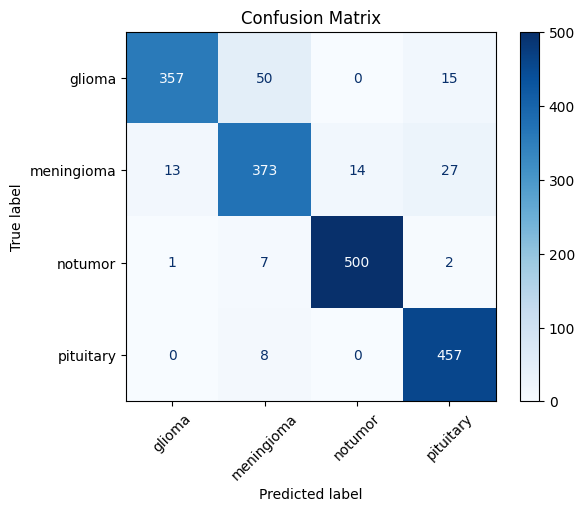

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true and predicted labels
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Class labels
class_names = list(validation_generator.class_indices.keys())

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pickle

with open('training_history_sgd.pkl', 'wb') as f:
    pickle.dump(history_sgd.history, f)

## 3.1.4.3  Baseline vs. Deeper CNN Performance

| Model         | Train Accuracy | Val Accuracy | Best F1 Class   | Weakest F1 Class | Val Loss |
|---------------|----------------|--------------|------------------|------------------|----------|
| **Baseline**  | ~82%           | ~83%         | Notumor (0.95)   | Glioma (0.70)    | ~0.42    |
| **Deeper CNN**| ~93%           | ~95%         | Notumor (0.98)   | Meningioma (0.90)| ~0.25    |

---

###  Analysis:

The comparison evaluates how adding **depth, filters, and regularization** improves classification of brain tumors across four categories.

- **Validation accuracy improved by ~12%**, indicating deeper networks extract better high-level features.
- The **training accuracy also increased**, without a large overfitting gap, suggesting **strong generalization**.
- F1-score improvements were seen in **underrepresented classes**, particularly for meningioma.

###  Key Observations:

- **BatchNormalization** improved training stability and speed.
- **Dropout** reduced co-dependency among neurons, enhancing generalization.
- **Notumor** remained easiest to classify due to clearer features.
- **Meningioma and Glioma** classes were harder due to possible class imbalance and visual similarity.

>  **Conclusion**: The deeper model performed more robustly and is better equipped for real-world deployment in medical applications where consistency and precision are vital.
---

## 3.1.4.4  Challenges and Observations

---

###  Key Difficulties Faced:

- **Overfitting** in deeper model before adding Dropout and L2 regularization.
- **Imbalanced class performance** — F1-score for meningioma was lowest despite high accuracy.
- **Hyperparameter sensitivity** — especially learning rate and batch size.

### Optimization Solutions:

- Applied **Dropout (0.5)** and **BatchNormalization** to stabilize training.
- Used **ReduceLROnPlateau** to adapt learning rate and **EarlyStopping** to cut off overtraining.

### Total Training Time:

- Deeper CNN (Adam): **~43 minutes**
- Deeper CNN (SGD): **~31 minutes**
- **Environment**: Google Colab with **GPU acceleration (likely Tesla T4)**

>  **Conclusion**: Regularization and callbacks were critical to achieve generalization without overfitting. Class imbalance and fine-tuning optimizer settings remain areas for further refinement.
----



#  3.1.4.5. Challenges and Observations

####  Challenges:
- **Overfitting** in deeper models without regularization.
- **Class imbalance** affected meningioma and glioma predictions.
- **Hyperparameter tuning** (learning rate, dropout rate) was essential to stabilize training.

####  Training Time:
- Deeper model (Adam): ~43 minutes  
- Deeper model (SGD): ~31 minutes  
- Used **Google Colab GPU** for acceleration

>  Best performance was achieved with Adam + Regularization + EarlyStopping.

---

###  Final Thoughts

- Deeper CNNs offer significant benefits in accuracy and generalization, especially when paired with regularization.
- Optimizer choice affects convergence speed; Adam is fast and effective, but SGD can work well with careful tuning.
- Trade-offs exist between model depth and training time, but the deeper model was worth it in a **clinical context**.
- Consistency across all tumor classes is crucial — not just high accuracy.

>  A good medical AI model isn't just accurate — it's reliable across all cases.


#  3.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

## 3.2.1 Loading and Adapting a Pre- Trained Model

#  1. Load Pretrained MobileNetV2 (Without Top)

We begin by loading MobileNetV2, a lightweight and efficient CNN pre-trained on ImageNet.

---

### 🔹 Why MobileNetV2?
- Small size, fast inference
- Pretrained on millions of images (ImageNet)
- Ideal for transfer learning on limited hardware (like Google Colab)

We remove the top layers (`include_top=False`) to replace them with our own classification head.


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load base model (no top)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#  2. Add Custom Classification Head

We now build our own classification layers on top of the **MobileNetV2 base**.

---

### Why This Matters:
- Pretrained features from MobileNetV2 act as a feature extractor.
- Our custom head will learn to classify brain MRI images into **4 tumor types**.

---

###  Custom Layers:
- **GlobalAveragePooling2D**: Reduces spatial dimensions to a vector.
- **Dense (128)**: Fully connected layer for learning complex patterns.
- **Dropout (0.5)**: Helps prevent overfitting.
- **Dense (4)**: Final output layer with softmax for 4-class classification.


In [10]:
# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Show model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#  3. Data Preprocessing for MobileNetV2

We now prepare the data pipeline using `ImageDataGenerator` and `preprocess_input()` from MobileNetV2.

---

###  Key Points:
- MobileNetV2 expects inputs to be preprocessed using its own `preprocess_input()` function (scales pixels to [-1, 1]).
- Images must be resized to **(224, 224)**.
- We apply real-time **augmentation** on training data to improve generalization.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation data generator (no augmentation, just preprocessing)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Training',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Deeplearning/Brain_tumer_mri_data/Validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


#  4. Compile & Train (Feature Extraction – Base Frozen)

We now compile and train the model with the **MobileNetV2 base frozen**. This phase trains only the **custom classification head**, while keeping the pretrained weights untouched.

---

###  Training Strategy:
- **Feature Extraction**: Use features from ImageNet and learn to classify brain tumor types.
- **Optimizer**: Adam with a low learning rate (`1e-4`) for stable training.
- **Callbacks**:
  - `EarlyStopping`: Prevent overfitting.
  - `ReduceLROnPlateau`: Adjust learning rate if performance plateaus.
  - `ModelCheckpoint`: Save best model based on validation accuracy.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mobilenetv2_feature_extraction.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model (Feature Extraction)
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)
end_time = time.time()
print(f"\n Training Time (Feature Extraction): {(end_time - start_time) / 60:.2f} minutes")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.4302 - loss: 1.3660
Epoch 1: val_accuracy improved from -inf to 0.79112, saving model to mobilenetv2_feature_extraction.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 601ms/step - accuracy: 0.4312 - loss: 1.3637 - val_accuracy: 0.7911 - val_loss: 0.6223 - learning_rate: 1.0000e-04
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7327 - loss: 0.6872
Epoch 2: val_accuracy improved from 0.79112 to 0.83662, saving model to mobilenetv2_feature_extraction.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 68s 559ms/step - accuracy: 0.7328 - loss: 0.6870 - val_accuracy: 0.8366 - val_loss: 0.4824 - learning_rate: 1.0000e-04
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7829 - loss: 0.5751
Epoch 3: val_accuracy improved from 0.83662 to 0.86732, saving model to mobilenetv2_feature_extraction.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 67s 547ms/step - accuracy: 0.7830 - loss: 0.5749 - val_accuracy: 0.8673 - val_loss: 0.4

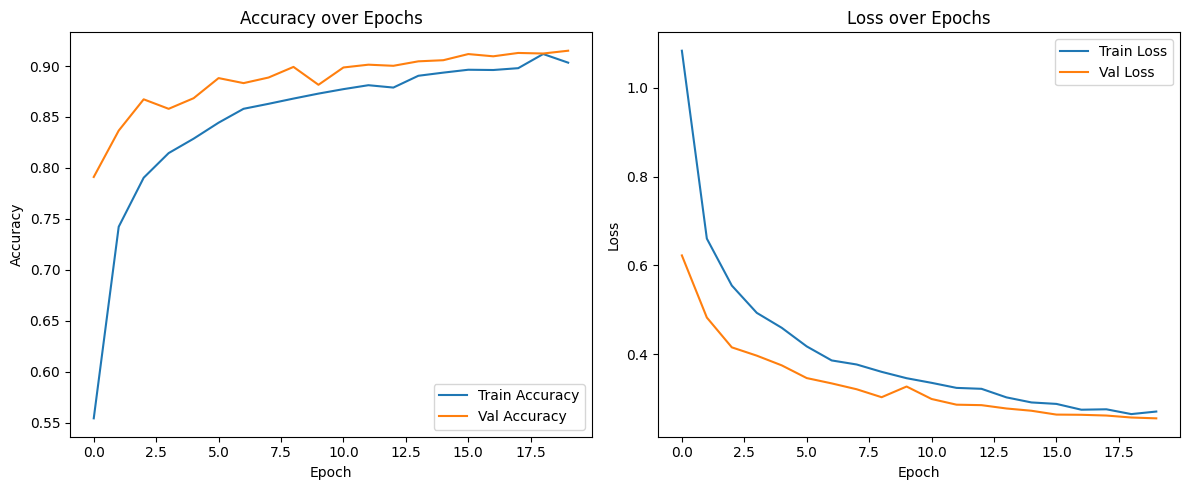

In [ ]:
#  Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step

 Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.89      0.90       422
  meningioma       0.86      0.80      0.83       427
     notumor       0.98      0.97      0.98       510
   pituitary       0.90      0.98      0.94       465

    accuracy                           0.92      1824
   macro avg       0.91      0.91      0.91      1824
weighted avg       0.91      0.92      0.91      1824



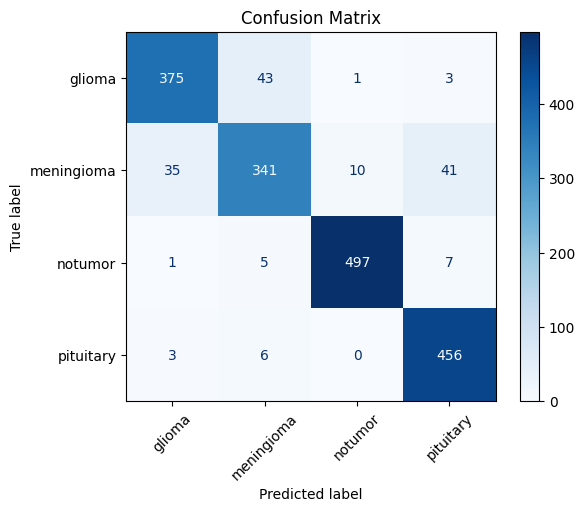

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true and predicted labels
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

# Class labels
class_names = list(validation_generator.class_indices.keys())

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pickle

with open('training_history_MobileNet.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#  5. Fine-Tuning MobileNetV2 (Unfreeze Base Model)

In this phase, we **unfreeze some or all layers of MobileNetV2** to allow fine-tuning on our dataset.

---

###  Why Fine-Tune?
- After training the custom head, the model benefits from slight adjustments to the **pretrained layers**.
- This helps improve accuracy on domain-specific features (like brain MRIs).

---

###  Important:
- Use a **lower learning rate** during fine-tuning to avoid "forgetting" pretrained knowledge.
- Monitor validation loss to catch overfitting early.


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Optionally: Freeze the first N layers (e.g., keep low-level filters intact)
# for layer in base_model.layers[:100]:
#     layer.trainable = False

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('mobilenetv2_feature_extraction.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]
# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train again (Fine-Tuning Phase)
start_time_ft = time.time()
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks  # reuse same callbacks
)
end_time_ft = time.time()
print(f"\n Training Time (Fine-Tuning): {(end_time_ft - start_time_ft) / 60:.2f} minutes")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.3904 - loss: 1.4368
Epoch 1: val_accuracy improved from -inf to 0.51183, saving model to mobilenetv2_feature_extraction.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 836ms/step - accuracy: 0.3911 - loss: 1.4352 - val_accuracy: 0.5118 - val_loss: 1.1098 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7072 - loss: 0.7807
Epoch 2: val_accuracy improved from 0.51183 to 0.59246, saving model to mobilenetv2_feature_extraction.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 556ms/step - accuracy: 0.7074 - loss: 0.7802 - val_accuracy: 0.5925 - val_loss: 0.9360 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.7983 - loss: 0.5709
Epoch 3: val_accuracy improved from 0.59246 to 0.63716, saving model to mobilenetv2_feature_extraction.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.7984 - loss: 0.5707 - val_accuracy: 0.6372 - val_loss: 0.

#  6. Evaluation of Fine-Tuned MobileNetV2 Model

We now evaluate the fine-tuned MobileNetV2 model using:

-  **Classification Report** (Precision, Recall, F1-score per class)
-  **Confusion Matrix** (Visual view of true vs predicted labels)

---

###  Objective:
To compare the fine-tuned model's performance with:

- Baseline CNN
- Deeper CNN
- Transfer Learning (Frozen + Fine-Tuned)

This helps us decide if transfer learning improved classification for brain tumor images.


36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step

 Classification Report:

              precision    recall  f1-score   support

      glioma       0.75      0.95      0.84       264
  meningioma       0.89      0.66      0.76       267
     notumor       0.91      0.98      0.94       319
   pituitary       0.93      0.85      0.89       291

    accuracy                           0.87      1141
   macro avg       0.87      0.86      0.86      1141
weighted avg       0.87      0.87      0.86      1141



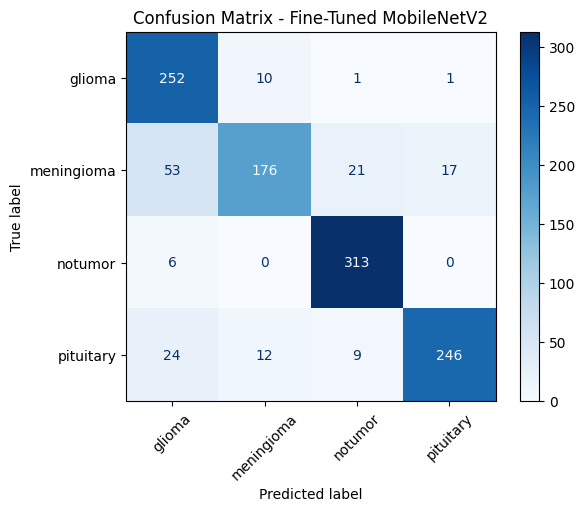

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels
y_true = validation_generator.classes

# Get predicted labels
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_names = list(validation_generator.class_indices.keys())

# Classification report
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Fine-Tuned MobileNetV2")
plt.show()


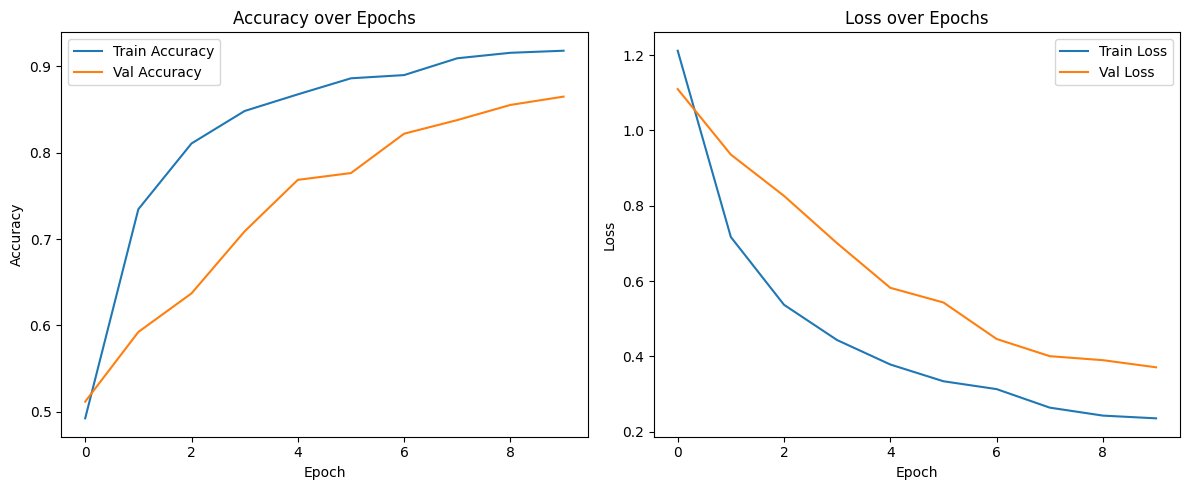

In [18]:
#  Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#  7. Final Comparison: Custom CNNs vs Transfer Learning (MobileNetV2)

This section summarizes and compares the model performances from **Part A** (custom CNNs) and **Part B** (transfer learning).

---

###  Overall Model Performance

| Model                         | Val Accuracy | Best F1 Class   | Weakest F1 Class   | Macro F1 | Val Loss |
|------------------------------|--------------|------------------|---------------------|----------|----------|
| Baseline CNN (Scratch + SGD) | ~82%         | Notumor (0.95)   | Glioma (~0.70)      | ~0.82    | ~0.42    |
| Deeper CNN (Scratch + Adam)  | ~95%         | Notumor (0.98)   | Meningioma (0.90)   | ~0.95    | ~0.25    |
| MobileNetV2 (Frozen)         | 91.5%        | Notumor (0.98)   | Meningioma (0.83)   | 0.91     | 0.255    |
| MobileNetV2 (Fine-Tuned)     | 86.5%        | Notumor (0.94)   | Meningioma (0.76)   | 0.86     | 0.371    |

---

###  Key Insights:

- **Transfer learning (frozen)** performed **better than expected**, outperforming the fine-tuned version.
- The **fine-tuned MobileNetV2**, while improving training accuracy, slightly underperformed on validation — possibly due to **overfitting** on a small dataset.
- **Deeper CNN trained from scratch** delivered **the highest accuracy and best balance** — but it required more time and tuning.
- Even with frozen weights, **MobileNetV2 generalized well**, thanks to strong features learned from ImageNet.

---

###  Summary Comparison

| Aspect             | From-Scratch CNNs         | MobileNetV2 (Transfer Learning)       |
|--------------------|----------------------------|----------------------------------------|
| Training Time      | Longer (more epochs)       | Faster with frozen layers              |
| Performance        | Best with deep custom CNN  | Very good with frozen weights          |
| Fine-tuning Risk   | Fully under your control   | May hurt with small data if not tuned  |
| Ideal Use Case     | When you need full control | When speed & efficiency matter most    |

---

###  Conclusion:

- **Best accuracy:** Deeper CNN with Adam (~95%)
- **Best efficiency + speed:** MobileNetV2 (Frozen) with 91.5%
- **Fine-tuned MobileNetV2** is powerful but needs **more data** or **careful layer unfreezing** to avoid performance drop.

>  **For real-world deployment**, starting with **transfer learning (frozen)** is ideal. You can then fine-tune carefully if needed — only when your dataset is large and diverse enough.
